In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
import torch.optim as optim
import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [68]:
#cnn model
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.fc1 = torch.nn.Linear(7*7*32, 10)
        self.softmax = torch.nn.Softmax(dim=10)

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 7*7*32)
        x = self.fc1(x)
        #y_pred = self.softmax(x)
        return x

    def eval2(self, x): return self.forward(x)

In [84]:
#utility functions

def train_cnn(model, train_loader, test_loader):

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    output = pd.DataFrame(columns=['epoch', 'train_loss', 'test_loss', 'train_acc', 'test_acc'])

    for epoch in range(5):
        for images, labels in train_loader:
            images = Variable(images)
            labels = Variable(labels)
            optimizer.zero_grad()
            y_pred = model(images)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            correct = 0
            total = 0
            train_loss = 0
            n=0
            for images, labels in train_loader:

                y_pred = model(images)
                train_loss += criterion(y_pred, labels).item()
                _, predicted = torch.max(y_pred.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                n+=1
            
            train_loss = train_loss/n    
            train_accuracy = 100 * correct / total

            correct = 0
            total = 0
            test_loss = 0
            n=0
            for images, labels in test_loader:

                y_pred = model.eval2(images)
                test_loss += criterion(y_pred, labels).item()
                _, predicted = torch.max(y_pred.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                n+=1

            test_loss = test_loss/n
            test_accuracy = 100 * correct / total
            print('Epoch: {}. Train Loss: {}. Test Loss: {}. Train Accuracy: {}. Test Accuracy: {}'.format(epoch, train_loss, test_loss, train_accuracy, test_accuracy))
            output.loc[epoch] = [epoch, train_loss, test_loss, train_accuracy, test_accuracy]
    
    return output


def get_adversarial(model, loader, attack, target, *args):
    total_loss, total_err = 0.,0.
    X_adv = []
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        if not target:
            delta = attack(model, X, y, *args)
        else:
            y_target = torch.argsort(model(X), dim=1)[:, -2]
            delta = attack(model, X, y_target, *args)
        X_adv.append(X+delta)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        
        if not target:
            total_err += (yp.max(dim=1)[1] != y).sum().item()
        else:
            total_err += (yp.max(dim=1)[1] == y_target).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset), torch.cat(X_adv)

def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()


def plot_images_target(X,yt,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*2))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}. \n Target: {}".format(yp[i*N+j].max(dim=0)[1], yt[i*N+j]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == yt[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

In [32]:
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=256, shuffle=True)


cnn_model = CNN()
train_cnn(cnn_model, train_loader, test_loader).to_csv('cnn.csv')

Epoch: 0. Train Loss: 0.6323601058188905. Test Loss: 0.611336774379015. Train Accuracy: 83.92333333333333. Test Accuracy: 84.77
Epoch: 1. Train Loss: 0.3762122364754372. Test Loss: 0.37372461035847665. Train Accuracy: 88.84333333333333. Test Accuracy: 89.4
Epoch: 2. Train Loss: 0.3100414608387237. Test Loss: 0.2918616559356451. Train Accuracy: 90.71833333333333. Test Accuracy: 91.33
Epoch: 3. Train Loss: 0.2644770329937022. Test Loss: 0.2454034635797143. Train Accuracy: 91.88166666666666. Test Accuracy: 92.16
Epoch: 4. Train Loss: 0.2720198018753782. Test Loss: 0.25050234198570254. Train Accuracy: 91.295. Test Accuracy: 92.06


In [66]:
def pgd(model, X, y, epsilon, alpha, num_iter):

    delta = torch.rand_like(X, requires_grad=True)
    #set delta to be in the range of perturbation
    delta.data = delta.data * 2 * epsilon - epsilon

    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
        
    return delta.detach()


def pgd_target(model, X, y_target, epsilon, alpha, num_iter):

    delta = torch.rand_like(X, requires_grad=True)
    #set delta to be in the range of perturbation
    delta.data = delta.data * 2 * epsilon - epsilon

    #get fake labels as second highest probability
    #y_fake = torch.argsort(model(X), dim=1)[:, -2]

    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y_target)
        loss.backward()
        delta.data = (delta - alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

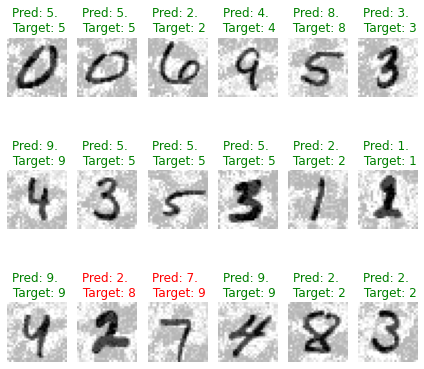

In [65]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break

y_fake = torch.argsort(cnn_model(X), dim=1)[:, -2]
delta = pgd_target(cnn_model, X, y_fake, epsilon=0.2, alpha=1e-2, num_iter=20)
yp = cnn_model(X + delta)
plot_images_target(X+delta, y_fake, yp, 3, 6)


In [92]:
error_rate, loss, adv = get_adversarial(cnn_model, test_loader, pgd, False, 0.3, 2e-2, 20)
print("Error rate: {:.2f}%".format(error_rate*100))
print("Loss: {:.4f}".format(loss))

torch.save(adv, "pgd_nonTarget_20.pt")


Error rate: 100.00%
Loss: 11.7985


In [93]:
error_rate, loss, adv = get_adversarial(cnn_model, test_loader, pgd, False, 0.3, 0.5, 1)
print("Error rate: {:.2f}%".format(error_rate*100))
print("Loss: {:.4f}".format(loss))

torch.save(adv, "pgd_nonTarget_1.pt")


Error rate: 99.97%
Loss: 11.4794


In [89]:
error_rate, loss, adv = get_adversarial(cnn_model, test_loader, pgd_target, True, 0.3, 2e-2, 20)
print("Error rate: {:.2f}%".format(error_rate*100))
print("Loss: {:.4f}".format(loss))

torch.save(adv, "pgd_Target_adv.pt")

y_target = []
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    y_target.append(torch.argsort(cnn_model(X), dim=1)[:, -2])

y_t = torch.cat(y_target)
torch.save(y_t, "pgd_Target_y.pt")

Error rate: 94.29%
Loss: 8.7472
